# Sound Event Classification with Convolutional Neural Networks

In this notebook we will walk you through an example of Sound Event Classification using Convolutional Neural Networks (CCNs). The network architecture is freely inspired to the resources:  https://towardsdatascience.com/cnns-for-audio-classification-6244954665ab and https://ieeexplore.ieee.org/document/9072379

### Import libraries

In [65]:
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
import tensorflow as tf
from glob import glob
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import seaborn as sns

### Explore the Dataset and Extract Acoustic Features

Our sound event dataset is composed by a few hundreds 1.5 seconds long sounds clips, representing the sound of a fictitious industrial machine. The dataset was arbitarily made up for this example and was not taken fron a real industrial environment. The sounds clips are divided into **three categories: ok, anomaly1, and anomaly2**, respectively representing machine sound in normal conditions, low severity anomalous sound and high severity anomaloud sound. 

As input features for our model, we will use **log-mel sound spectrogram** and **MFCC coefficients** . 

Let's extract acoustic features for one sample sound clip. The following cell computes and diplay the **log-mel spectrogram** using librosa python library

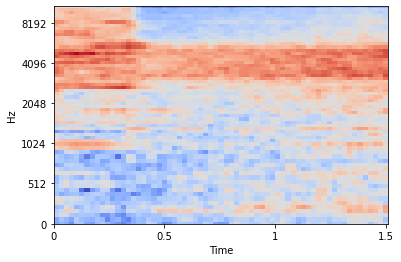

In [7]:
path = "../LGPsound/ok/clip0001.wav"
scale, sr = librosa.load(path)
mel_spectrogram = librosa.feature.melspectrogram(scale, 
                                                 sr, 
                                                 hop_length=512,
                                                 n_mels=64,
                                                 fmax=sr/2)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
librosa.display.specshow(log_mel_spectrogram, x_axis="time", y_axis="mel", sr=sr)

Let's now visualise **MFCCs** for the same sample sound clip.

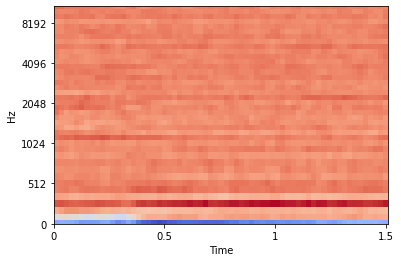

In [8]:
MFCCs=librosa.feature.mfcc(scale, sr, n_mfcc=40, fmax=sr/2)
librosa.display.specshow(MFCCs, x_axis="time", y_axis="mel", sr=sr)

The input features for our CNN will be made of log-mel spectrogam AND MFCCs stackd upon each other. Let's build the final feature and visualize it

In [10]:
acoustic_features=np.concatenate( (MFCCs,log_mel_spectrogram), axis =0)

In [11]:
acoustic_features.shape

(104, 65)

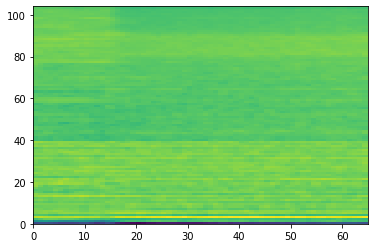

In [12]:
plt.pcolor(acoustic_features)
plt.show()

### Data preparation: Apply Feature Extraction to all Audio Clips

Let's write a function to ingest an arbitrary sound clip and return its acoustic features: log-mel spectrogram AND MFCCs, as we have done above for a single sound clip.

In [13]:
def acoustic_feature_computation( clip ):
    scale, sr = librosa.load(clip)
    mel_spectrogram = librosa.feature.melspectrogram(scale, 
                                                 sr, 
                                                 hop_length=512,
                                                 n_mels=64,
                                                 fmax=sr/2)
    log_mel = librosa.power_to_db(mel_spectrogram)
    MFCCs=librosa.feature.mfcc(scale, sr, n_mfcc=40, fmax=sr/2)
    acoustic_features=np.concatenate( (MFCCs,log_mel_spectrogram), axis =0)
    return acoustic_features


 Split the dataset into train, test and validation with a ration of 60:20:20

In [41]:
clips=glob('../LGPsound/*/*')
clips_df=pd.DataFrame(data={'path':clips,
                            'label':[ c.split('/')[-2]  for c in clips]} )

class_dict=dict(enumerate(clips_df.label.unique() ))
classes = {v: k for k, v in class_dict.items()}
clips_df['class']=clips_df['label'].apply(lambda x : classes[x])
clips_df

,path,label,class
0,../LGPsound/ok/clip0568.wav,ok,0
1,../LGPsound/ok/clip0226.wav,ok,0
2,../LGPsound/ok/clip0540.wav,ok,0
3,../LGPsound/ok/clip0554.wav,ok,0
4,../LGPsound/ok/clip0232.wav,ok,0
...,...,...,...
1003,../LGPsound/anomaly2/clip0161.wav,anomaly2,2
1004,../LGPsound/anomaly2/clip0175.wav,anomaly2,2
1005,../LGPsound/anomaly2/clip0613.wav,anomaly2,2
1006,../LGPsound/anomaly2/clip0773.wav,anomaly2,2


In [42]:
train, test = train_test_split(clips_df, test_size=0.20, random_state=25)
train, validation = train_test_split(train, test_size=0.20, random_state=25)

Apply the acoustic feature computation to train, test and validation folds

In [46]:
X_train=[] 
X_test=[]
X_validation=[]
y_train=[] 
y_test=[]
y_validation=[]

for i,r in train.iterrows():
    X_train.append(acoustic_feature_computation(r['path']))
    y_train.append(r['class'])
    
for i,r in test.iterrows():
    X_test.append(acoustic_feature_computation(r['path']))
    y_test.append(r['class'])
    
for i,r in validation.iterrows():
    X_validation.append(acoustic_feature_computation(r['path']))
    y_validation.append(r['class'])

### Build a 2D CNN

Let's build our Convolutional neural Network using TensorFlow

In [47]:
initializer = tf.keras.initializers.GlorotUniform()

input_shape=(104,65,1)
CNNmodel = models.Sequential(name = "CNN2")

# Block 1
CNNmodel.add(layers.Conv2D(32, (4, 4),(2,2), activation='relu', input_shape=input_shape, kernel_initializer=initializer, name ='block1_cnn1'))
CNNmodel.add(layers.BatchNormalization())
CNNmodel.add(layers.Conv2D(32, (4, 4),(2,2), activation='relu', kernel_initializer=initializer, name ='block1_cnn2'))
CNNmodel.add(layers.BatchNormalization())
CNNmodel.add(layers.MaxPooling2D((2, 2), name ='block1_maxpool'))

# FC layers
CNNmodel.add(layers.Flatten())
CNNmodel.add(layers.Dense(512, activation='relu',kernel_initializer=initializer,name='FC1' ))
CNNmodel.add(layers.Dropout(0.5))
CNNmodel.add(layers.Dense(64, activation='relu',kernel_initializer=initializer,name='FC2' ))
CNNmodel.add(layers.Dropout(0.5))

# Output
CNNmodel.add(layers.Dense(3, activation='softmax'))


In [49]:
CNNmodel.summary()

Model: "CNN2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_cnn1 (Conv2D)        (None, 51, 31, 32)        544       
                                                                 
 batch_normalization_6 (Batc  (None, 51, 31, 32)       128       
 hNormalization)                                                 
                                                                 
 block1_cnn2 (Conv2D)        (None, 24, 14, 32)        16416     
                                                                 
 batch_normalization_7 (Batc  (None, 24, 14, 32)       128       
 hNormalization)                                                 
                                                                 
 block1_maxpool (MaxPooling2  (None, 12, 7, 32)        0         
 D)                                                              
                                                              

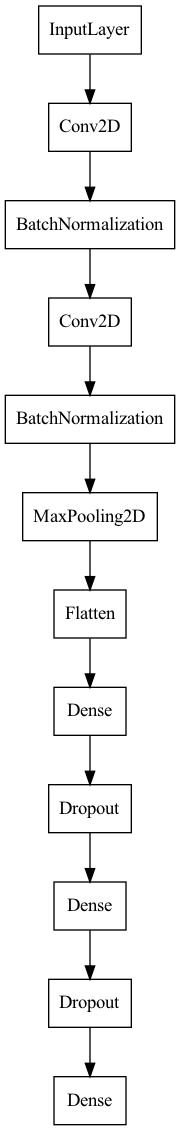

In [51]:
tf.keras.utils.plot_model(CNNmodel, to_file='model_plot.png', rankdir='TB',show_shapes=False,dpi=96, show_layer_names=False)

Choose the optimizer and train the network 

In [54]:
CNNmodel.compile(optimizer= "adam",
              loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics = ['accuracy'])

In [52]:
ep=100
history = CNNmodel.fit(x=np.array(X_train, np.float32), 
                       y=np.array(y_train, np.float32), 
                       validation_data = ( np.array(X_validation, np.float32),
                                           np.array(y_validation, np.float32),
                                           ),
                       epochs=ep
                      )

Epoch 1/100


/Users/I550349/workspace/venv3.8/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


21/21 [==============================] - 2s 56ms/step - loss: 1.5270 - accuracy: 0.5699 - val_loss: 0.4455 - val_accuracy: 0.8395
Epoch 2/100
21/21 [==============================] - 1s 54ms/step - loss: 0.4585 - accuracy: 0.8199 - val_loss: 0.5830 - val_accuracy: 0.7840
Epoch 3/100
21/21 [==============================] - 1s 53ms/step - loss: 0.2221 - accuracy: 0.9270 - val_loss: 0.9775 - val_accuracy: 0.8086
Epoch 4/100
21/21 [==============================] - 1s 53ms/step - loss: 0.1589 - accuracy: 0.9472 - val_loss: 0.3875 - val_accuracy: 0.8210
Epoch 5/100
21/21 [==============================] - 1s 53ms/step - loss: 0.1173 - accuracy: 0.9550 - val_loss: 0.1167 - val_accuracy: 0.9630
Epoch 6/100
21/21 [==============================] - 1s 49ms/step - loss: 0.1533 - accuracy: 0.9627 - val_loss: 0.2458 - val_accuracy: 0.9012
Epoch 7/100
21/21 [==============================] - 1s 51ms/step - loss: 0.1666 - accuracy: 0.9472 - val_loss: 0.2528 - val_accuracy: 0.9198
Epoch 8/100
21/21 

#### Visualize how model loss and accuracy metric evolved during training

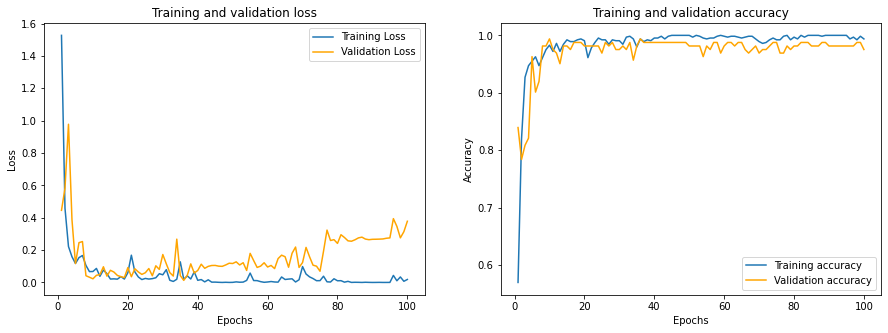

In [53]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,ep+1)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,label='Training Loss')
ax1.plot(epochs,val_loss_values,'orange', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(epochs,acc_values, label='Training accuracy')
ax2.plot(epochs,val_acc_values,'orange',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

#### Evaluate model performace on the test set

In [55]:
score = CNNmodel.evaluate(np.array(X_test, np.float32), np.array(y_test, np.float32))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 18ms/step - loss: 0.1865 - accuracy: 0.9950
Test loss: 0.18645921349525452
Test accuracy: 0.9950494766235352


We obtained a pretty good accuracy on the test set. Let's see how we can get the predicted class for every sound clip in the test set:

In [59]:
pred=CNNmodel(np.array(X_test, np.float32) , training=False)
pred[:10]

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[1.00000000e+00, 2.18793346e-18, 1.63977197e-21],
       [1.00000000e+00, 1.71413841e-10, 3.31342945e-13],
       [1.00000000e+00, 5.22700293e-17, 1.15379465e-20],
       [3.27555483e-11, 4.83906692e-10, 1.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 2.38373033e-32],
       [2.83108044e-08, 2.63333561e-07, 9.99999762e-01],
       [1.00000000e+00, 7.13130707e-19, 2.23529379e-19],
       [3.99793418e-20, 1.00000000e+00, 1.95492624e-12]], dtype=float32)>

The tensorflow model outputs an array of dimension 3 for each sound clip. The array elements represents the probability of a given sound clip to belong to each of the classes: ok, anomaly1 and anomaly2. We can associate the most likely class to each sound clip by looking for the makimum probability in this array.

In [62]:
pred_class = [ np.where(arr == np.amax(arr))[0][0] for arr in np.array(pred) ]
pred_label = [ class_dict[i]  for i in pred_class]
pred_confidence = [ np.max(arr) for arr in np.array(pred)]

Now we can extract and visualize the confusion matrix for this classification model

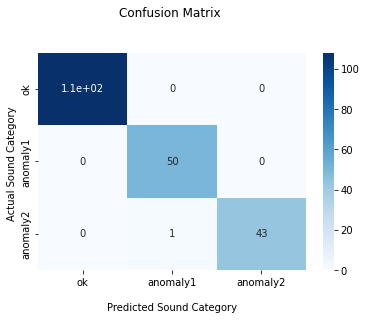

In [68]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, pred_class)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix \n\n')
ax.set_xlabel('\nPredicted Sound Category')
ax.set_ylabel('Actual Sound Category ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['ok','anomaly1','anomaly2'])
ax.yaxis.set_ticklabels(['ok','anomaly1','anomaly2'])

## Display the visualization of the Confusion Matrix.
plt.show()